In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [2]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

In [3]:
train_data.shape

(404, 13)

In [4]:
print(train_data[0],'\n', train_targets[0])

[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ] 
 15.2


# Preparing the data

In [5]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

# Building network

In [6]:
from keras import models
from keras import layers    

In [7]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [8]:
num_epochs = 100
model = build_model()
history = model.fit(train_data, train_targets, epochs=num_epochs, batch_size=1, verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [9]:
history.history

{'loss': [179.82141040890744,
  24.875692546261604,
  17.760219014171362,
  16.222692792589353,
  14.25547384306423,
  12.936025748359084,
  12.328134635892386,
  11.906036408585116,
  11.471945040046402,
  10.69320175200641,
  10.57512204796444,
  10.335403223074302,
  10.174227328070007,
  10.177753176740765,
  9.511339016046596,
  9.094737938312013,
  9.003402227110731,
  8.928268854072899,
  8.7566713522429,
  8.3780148575561,
  8.59979245804079,
  8.321096509081748,
  8.146922075596168,
  8.408186755303213,
  8.042902810650247,
  7.832312502652715,
  7.5028453742865135,
  7.704706608758537,
  7.576761815066468,
  7.556059518211729,
  7.3380811300089,
  6.989057322393567,
  7.534004555627743,
  6.92387664579607,
  6.9820710821276775,
  6.75659239368835,
  6.959890252248226,
  6.788785651903826,
  6.2449542497653585,
  6.712389097512047,
  6.363690684752058,
  6.502335414460297,
  5.967011392960468,
  6.180739180900243,
  6.284550975189938,
  6.126997411946507,
  6.1966751507961995,

In [10]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [11]:
all_scores

[2.0758312574707634, 2.3295178555025915, 2.489146102773081, 2.768011015240509]

In [12]:
test_mse, test_mae = model.evaluate(test_data, test_targets, verbose=0)

In [13]:
test_mae

2.804957380481795

# Find right epochs

In [14]:
from keras import backend as K
# Some memory clean-up
K.clear_session()

In [15]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [16]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

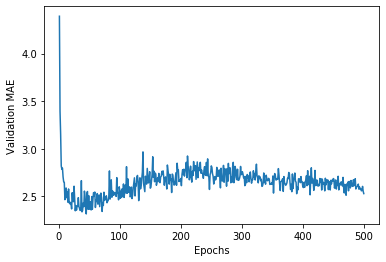

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [23]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

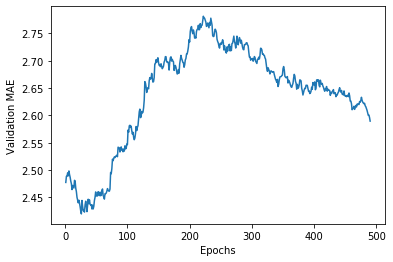

In [27]:
smooth_mae_history = smooth_curve(average_mae_history[10:],0.9)
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [30]:
model = build_model()
model.fit(train_data, train_targets, epochs=25, batch_size=16)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

Epoch 1/25
404/404 [==============================] - 1s 2ms/step - loss: 500.1797 - mean_absolute_error: 20.3968
Epoch 2/25
404/404 [==============================] - 0s 121us/step - loss: 331.1695 - mean_absolute_error: 15.8883
Epoch 3/25
404/404 [==============================] - 0s 122us/step - loss: 161.1016 - mean_absolute_error: 10.1658
Epoch 4/25
404/404 [==============================] - 0s 125us/step - loss: 73.6288 - mean_absolute_error: 6.3465
Epoch 5/25
404/404 [==============================] - 0s 147us/step - loss: 44.0634 - mean_absolute_error: 4.8768
Epoch 6/25
404/404 [==============================] - 0s 133us/step - loss: 31.0776 - mean_absolute_error: 3.9752
Epoch 7/25
404/404 [==============================] - 0s 129us/step - loss: 25.0020 - mean_absolute_error: 3.5253
Epoch 8/25
404/404 [==============================] - 0s 125us/step - loss: 22.2079 - mean_absolute_error: 3.2178
Epoch 9/25
404/404 [==============================] - 0s 220us/step - loss: 19.7712 

In [31]:
test_mae_score

3.281853759990019